In [27]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                            AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [28]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

In [29]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

In [30]:
def Data_Grouping(array_x, array_y, Group_K):
    Len = len(array_x)
    GP_num = int(Len/Group_K)
    if(Len%Group_K>0):
        GP_num += 1
    rt_x = []
    sig_x = []
    rt_y = []
    sig_y = []
    for i in range(GP_num):
        sum_x = []
        sum_y = []
        for t in range(Group_K):
            if((i*Group_K + t)< Len):
                sum_x += [array_x[i*Group_K + t]]
                sum_y += [array_y[i*Group_K + t]]
        rt_x += [np.mean(sum_x)]
        sig_x += [np.std(sum_x)]
        rt_y += [np.mean(sum_y)]
        sig_y += [np.std(sum_y)]

    return rt_x, rt_y, sig_x, sig_y

# Global Setting

In [31]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

# Data Pre-read

In [32]:
lam_range_temp = [4800, 5230]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [33]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [34]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

In [35]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 150
        Cut_RHS = 150

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [36]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

In [37]:
Fit_name = 'Fit_DS_07[24Dec07][VCC1588]'

In [38]:
Galaxy_P2P = pd.read_csv('./../FitData/'+Fit_name+'/'+galaxy_name+'_P2P_SFR.csv')
Galaxy_VNB = pd.read_csv('./../FitData/'+Fit_name+'/'+galaxy_name+'_VNB_SFR.csv')
Galaxy_RDB = pd.read_csv('./../FitData/'+Fit_name+'/'+galaxy_name+'_RDB_SFR.csv')

In [39]:
Galaxy_P2P['Index'] = Galaxy_P2P.index
Galaxy_VNB['Index'] = Galaxy_VNB.index
Galaxy_RDB['Index'] = Galaxy_RDB.index

In [40]:
# Galaxy_VNB['H_beta_EL_value'] = Galaxy_VNB['H_beta_EL_value']/(10**18)
# Galaxy_VNB['O_3_5007_EL_value'] = Galaxy_VNB['O_3_5007_EL_value']/(10**18)
# Galaxy_VNB['H_beta_SI'] = Galaxy_VNB['H_beta_SI']/(10**18)
# Galaxy_VNB['Mg_b_SI'] = Galaxy_VNB['Mg_b_SI']/(10**18)
# Galaxy_VNB['Fe_5015_SI'] = Galaxy_VNB['Fe_5015_SI']/(10**18)

# Galaxy_RDB['H_beta_EL_value'] = Galaxy_RDB['H_beta_EL_value']/(10**18)
# Galaxy_RDB['O_3_5007_EL_value'] = Galaxy_RDB['O_3_5007_EL_value']/(10**18)
# Galaxy_RDB['H_beta_SI'] = Galaxy_RDB['H_beta_SI']/(10**18)
# Galaxy_RDB['Mg_b_SI'] = Galaxy_RDB['Mg_b_SI']/(10**18)
# Galaxy_RDB['Fe_5015_SI'] = Galaxy_RDB['Fe_5015_SI']/(10**18)

In [41]:
SNR_Lim = 10
Galaxy_P2P_HSNR = Galaxy_P2P[ Galaxy_P2P['SNR'] >  SNR_Lim]
Galaxy_VNB_HSNR = Galaxy_VNB[ Galaxy_VNB['SNR'] >  SNR_Lim]
Galaxy_RDB_HSNR = Galaxy_RDB[ Galaxy_RDB['SNR'] >  SNR_Lim]

Galaxy_P2P_HSNR = TB_reindex(Galaxy_P2P_HSNR)
Galaxy_VNB_HSNR = TB_reindex(Galaxy_VNB_HSNR)
Galaxy_RDB_HSNR = TB_reindex(Galaxy_RDB_HSNR)

# Analysis

## SNR

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\2594082324.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


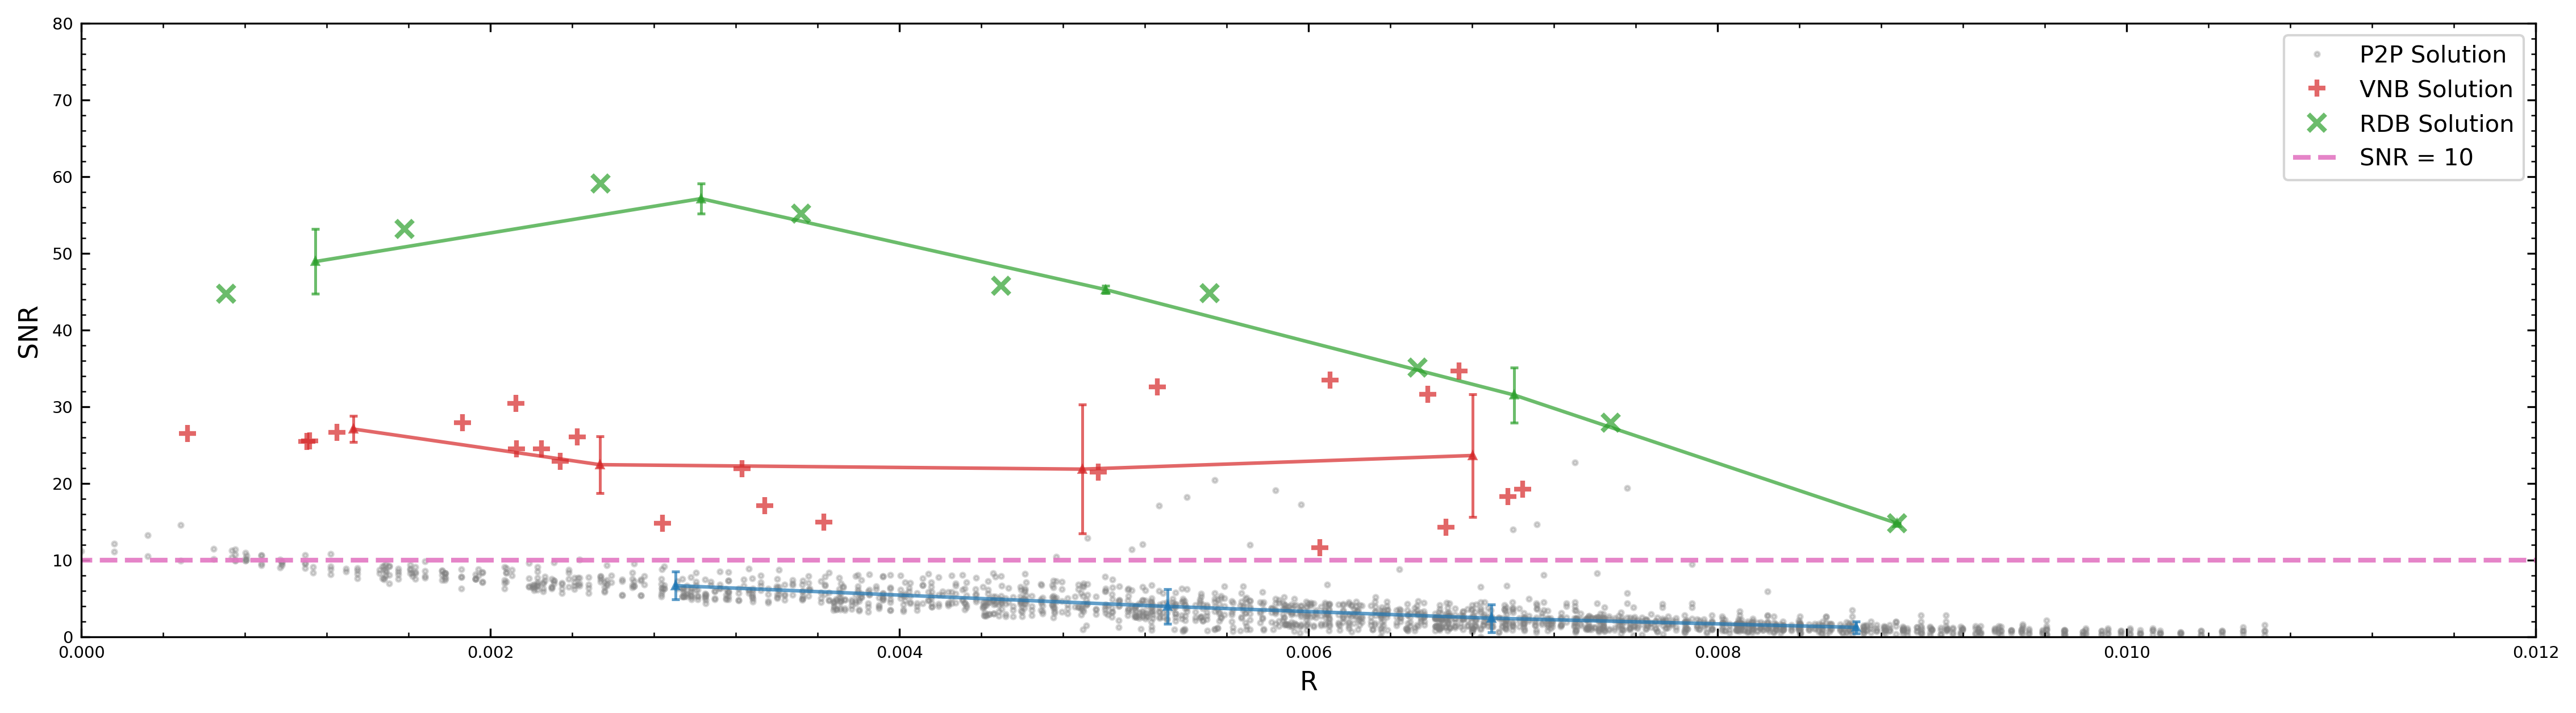

In [42]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P['R'], Galaxy_P2P['SNR'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution', zorder=0)
ax1.plot(Galaxy_VNB['R'], Galaxy_VNB['SNR'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution')
ax1.plot(Galaxy_RDB['R'], Galaxy_RDB['SNR'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution')

Galaxy_P2P_GP = Data_Grouping(array_x=np.array(Galaxy_P2P.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P.sort_values(by=['R'])['SNR']), Group_K=501)
Galaxy_VNB_GP = Data_Grouping(array_x=np.array(Galaxy_VNB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB.sort_values(by=['R'])['SNR']), Group_K=6)
Galaxy_RDB_GP = Data_Grouping(array_x=np.array(Galaxy_RDB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB.sort_values(by=['R'])['SNR']), Group_K=2)

ax1.errorbar(Galaxy_P2P_GP[0], Galaxy_P2P_GP[1], yerr=Galaxy_P2P_GP[3],color='tab:blue',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP[0], Galaxy_VNB_GP[1], yerr=Galaxy_VNB_GP[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP[0], Galaxy_RDB_GP[1], yerr=Galaxy_RDB_GP[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.plot([-1,1], [SNR_Lim,SNR_Lim], '--', color='tab:pink', lw=2, alpha=.9, label='SNR = {:}'.format(SNR_Lim))

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,80)
ax1.set_xlim(0,0.012)

ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'SNR', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## Fe/Mg

### Normal

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\67030061.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


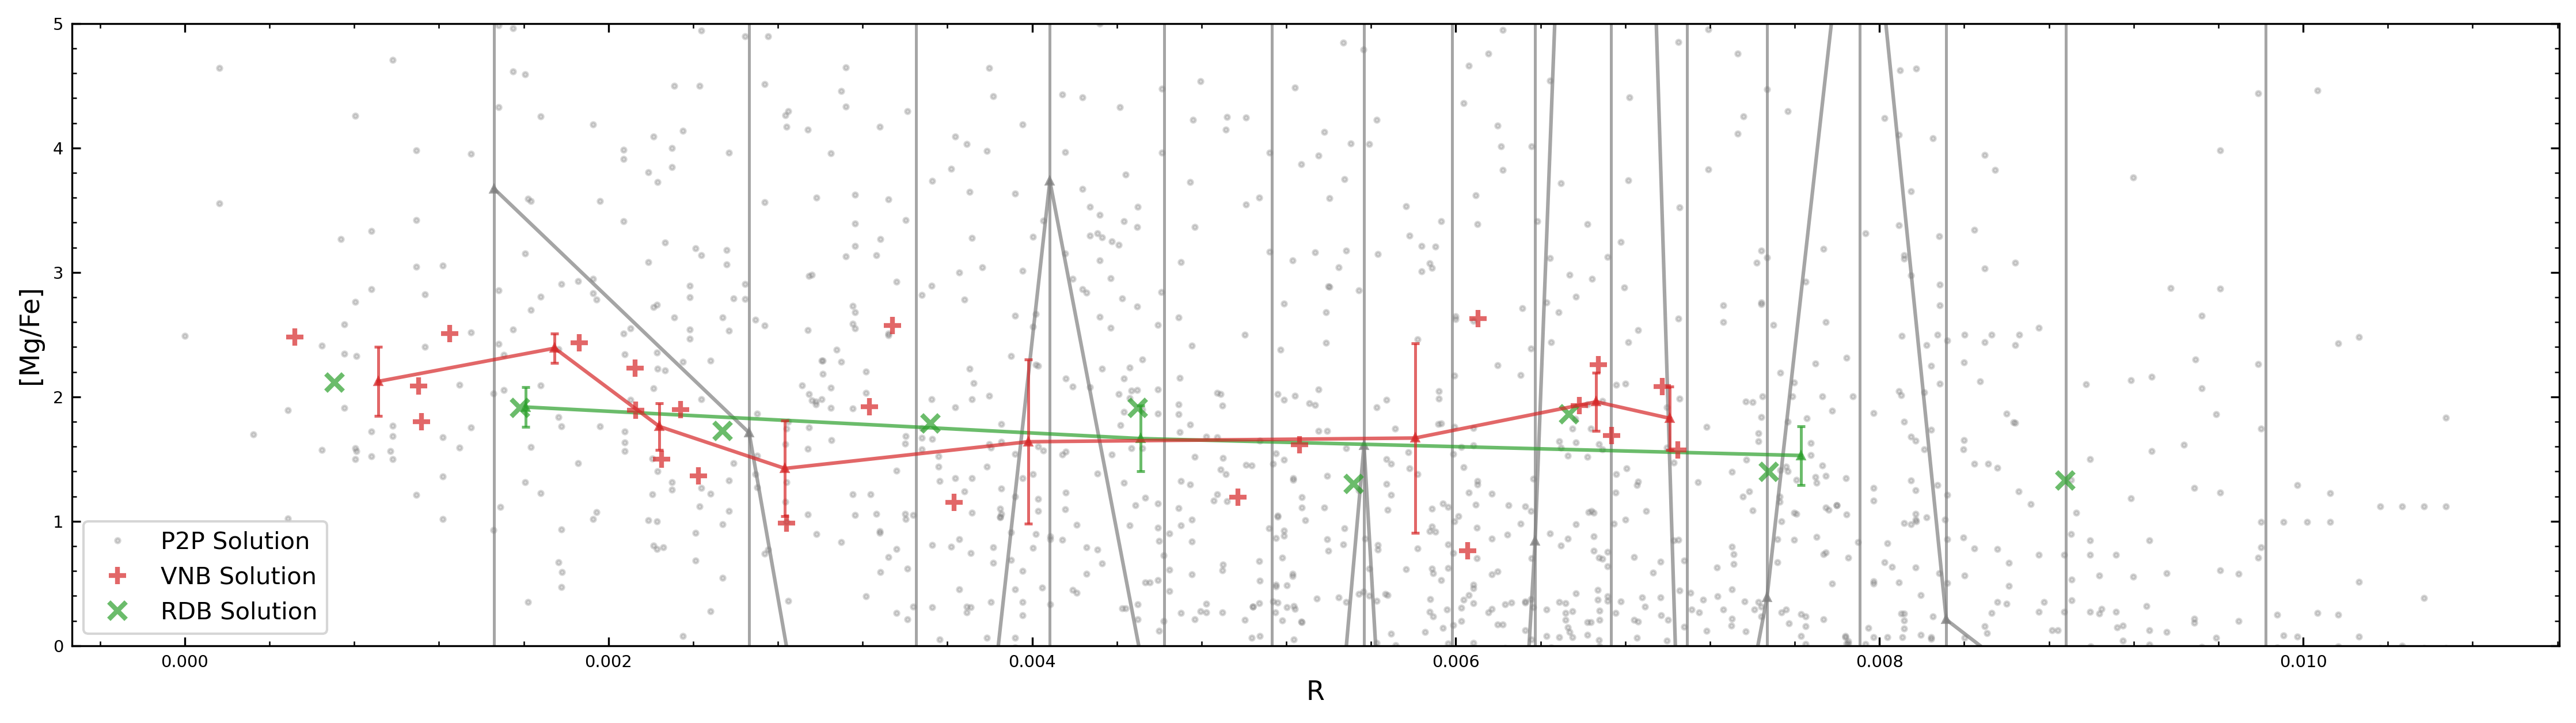

In [43]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P['R'], Galaxy_P2P['Mg_b_SI']/Galaxy_P2P['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution', zorder=0)
ax1.plot(Galaxy_VNB['R'], Galaxy_VNB['Mg_b_SI']/Galaxy_VNB['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution')
ax1.plot(Galaxy_RDB['R'], Galaxy_RDB['Mg_b_SI']/Galaxy_RDB['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution')

Galaxy_P2P_GP = Data_Grouping(array_x=np.array(Galaxy_P2P.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P.sort_values(by=['R'])['Mg_b_SI']/Galaxy_P2P.sort_values(by=['R'])['Fe_5015_SI']), Group_K=126)
Galaxy_VNB_GP = Data_Grouping(array_x=np.array(Galaxy_VNB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB.sort_values(by=['R'])['Mg_b_SI']/Galaxy_VNB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP = Data_Grouping(array_x=np.array(Galaxy_RDB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB.sort_values(by=['R'])['Mg_b_SI']/Galaxy_RDB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP[0], Galaxy_P2P_GP[1], yerr=Galaxy_P2P_GP[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP[0], Galaxy_VNB_GP[1], yerr=Galaxy_VNB_GP[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP[0], Galaxy_RDB_GP[1], yerr=Galaxy_RDB_GP[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,5)
# ax1.set_xlim(,)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg/Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

### SNR fliter

In [44]:
MgFeR_Lim = 1.3

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\2840661897.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


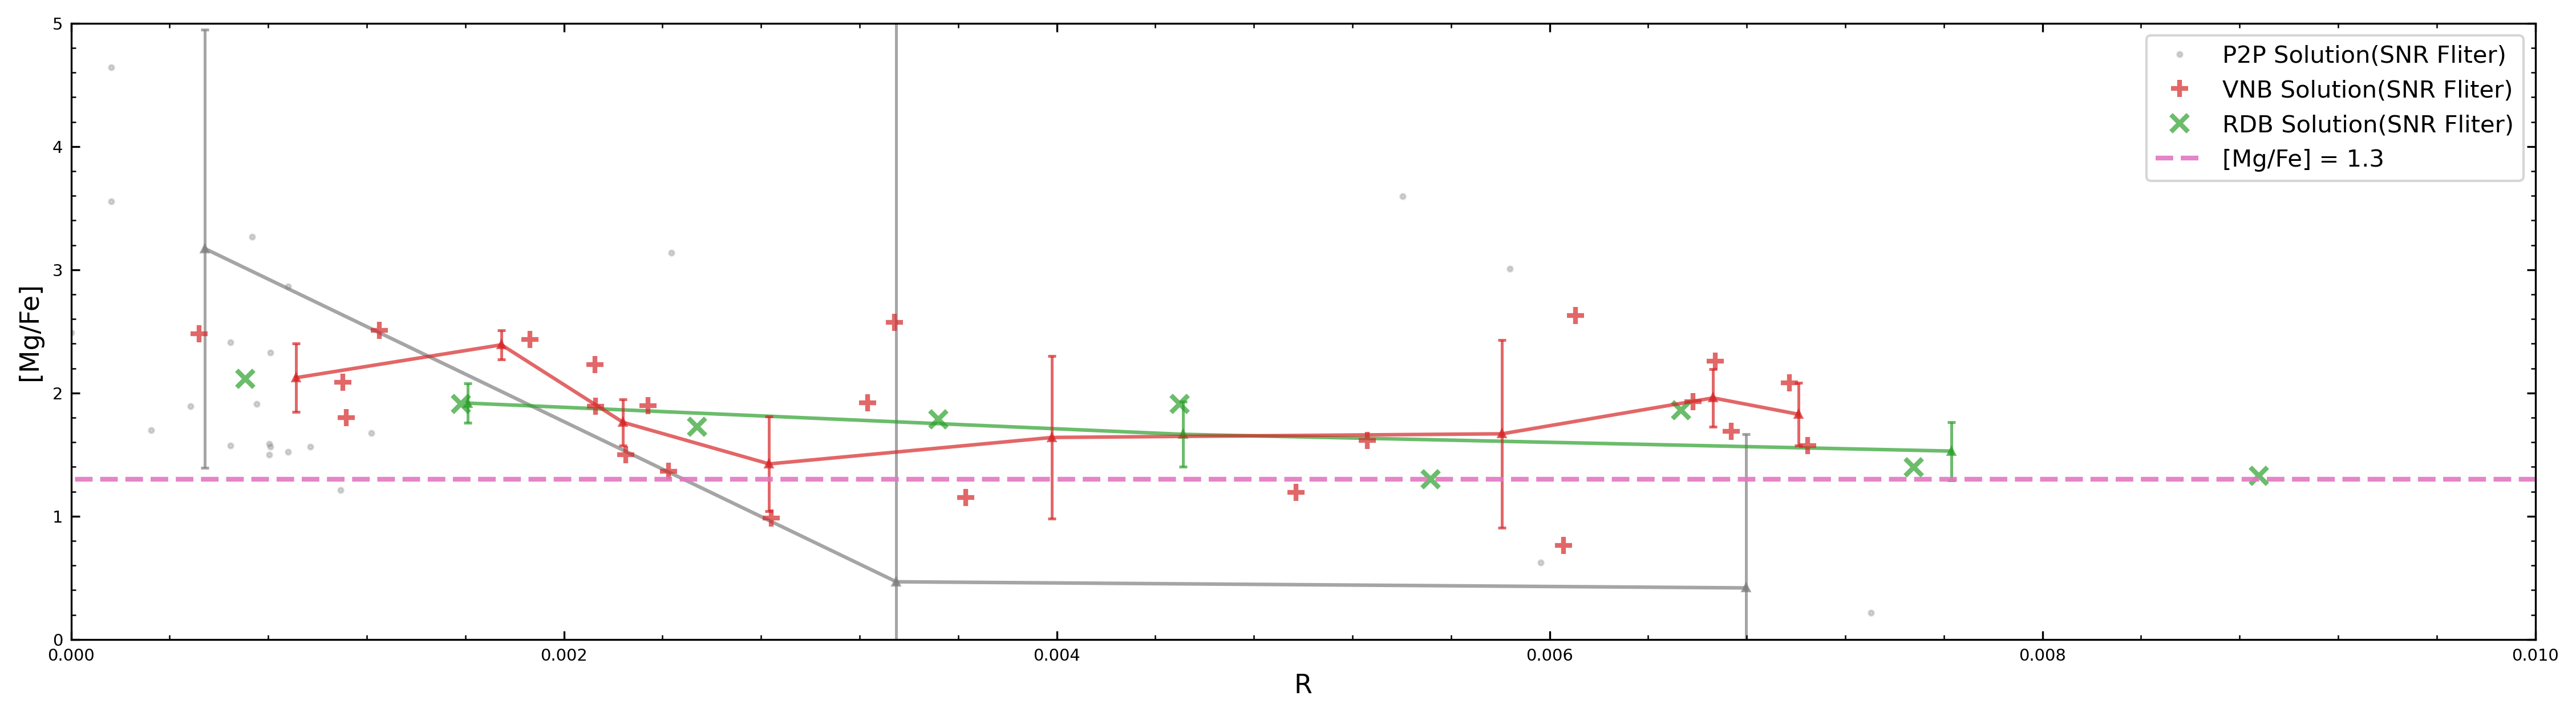

In [45]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['Mg_b_SI']/Galaxy_P2P_HSNR['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax1.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['Mg_b_SI']/Galaxy_VNB_HSNR['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax1.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['Mg_b_SI']/Galaxy_RDB_HSNR['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['Mg_b_SI']/Galaxy_P2P_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['Mg_b_SI']/Galaxy_VNB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['Mg_b_SI']/Galaxy_RDB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.plot([-1,1], [MgFeR_Lim,MgFeR_Lim], '--', color='tab:pink', lw=2, alpha=.9, label='[Mg/Fe] = {:}'.format(MgFeR_Lim))

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,5)
ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg/Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## Fe*Mg

### Normal

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3657147565.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


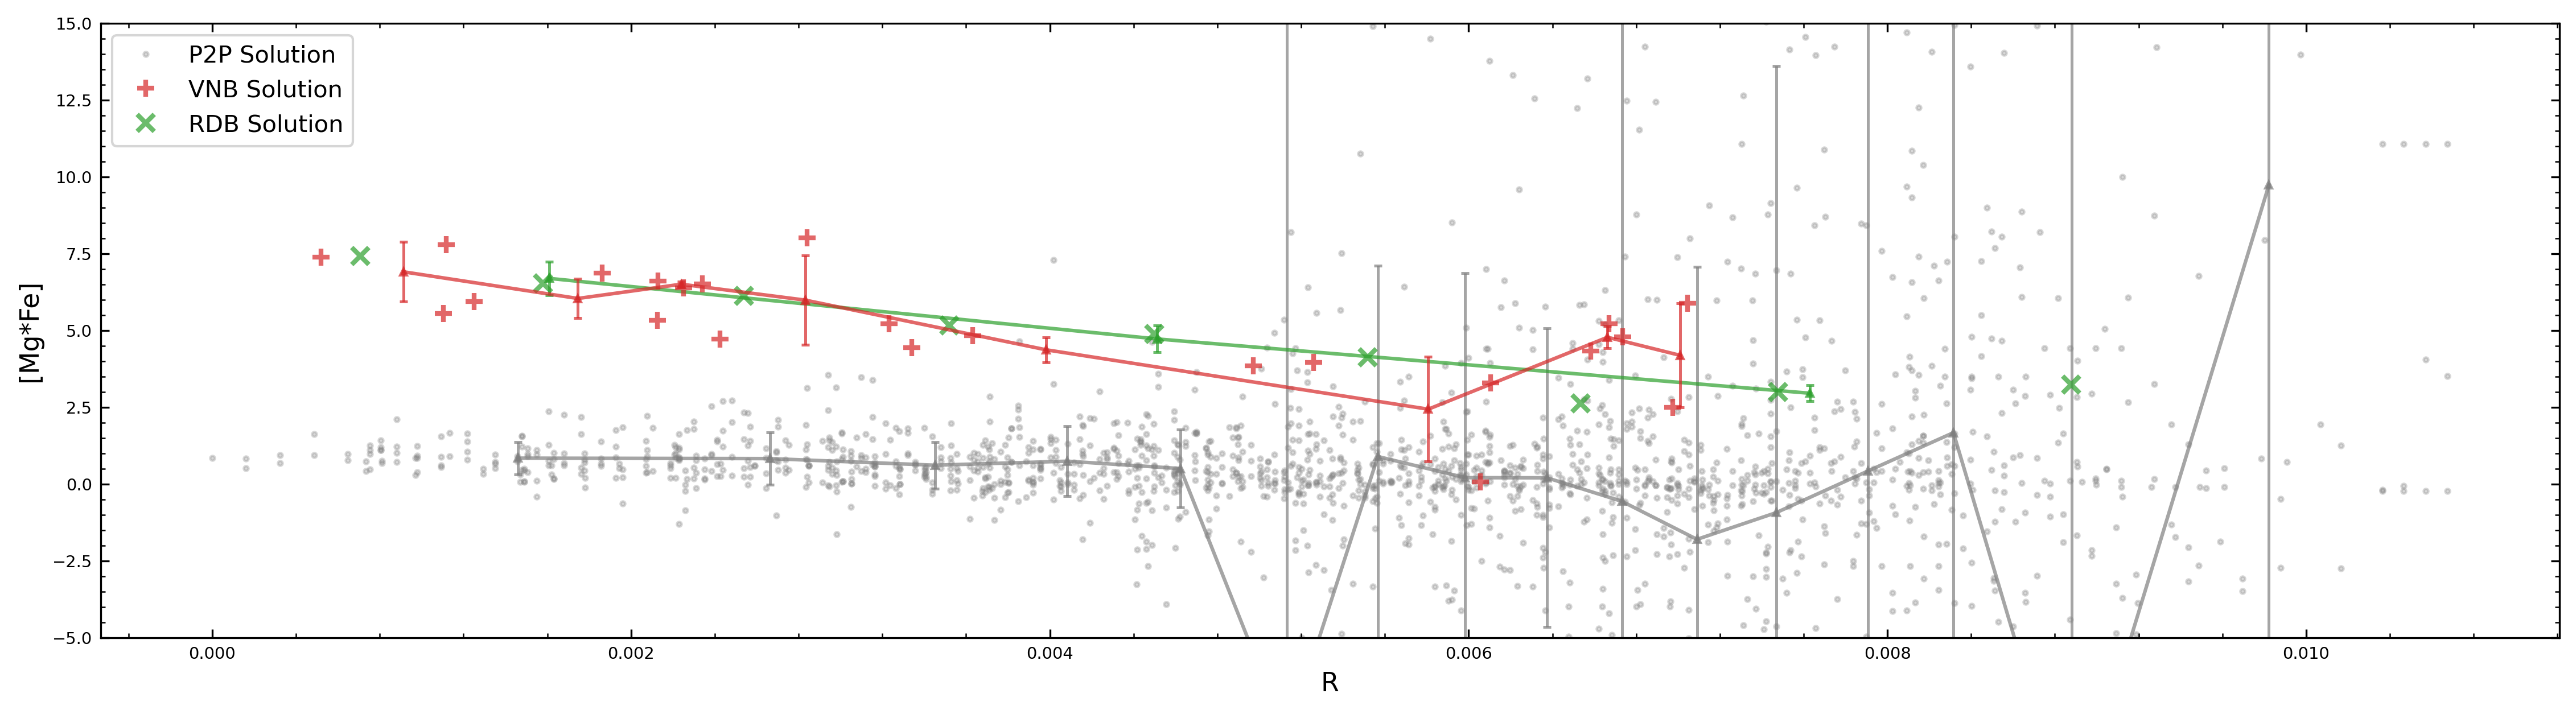

In [46]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P['R'], Galaxy_P2P['Mg_b_SI']*Galaxy_P2P['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution', zorder=0)
ax1.plot(Galaxy_VNB['R'], Galaxy_VNB['Mg_b_SI']*Galaxy_VNB['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution')
ax1.plot(Galaxy_RDB['R'], Galaxy_RDB['Mg_b_SI']*Galaxy_RDB['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution')

Galaxy_P2P_GP = Data_Grouping(array_x=np.array(Galaxy_P2P.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P.sort_values(by=['R'])['Mg_b_SI']*Galaxy_P2P.sort_values(by=['R'])['Fe_5015_SI']), Group_K=126)
Galaxy_VNB_GP = Data_Grouping(array_x=np.array(Galaxy_VNB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB.sort_values(by=['R'])['Mg_b_SI']*Galaxy_VNB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP = Data_Grouping(array_x=np.array(Galaxy_RDB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB.sort_values(by=['R'])['Mg_b_SI']*Galaxy_RDB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP[0], Galaxy_P2P_GP[1], yerr=Galaxy_P2P_GP[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP[0], Galaxy_VNB_GP[1], yerr=Galaxy_VNB_GP[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP[0], Galaxy_RDB_GP[1], yerr=Galaxy_RDB_GP[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(-5,15)
# ax1.set_xlim(,)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg*Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

### SNR fliter

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\1593515253.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


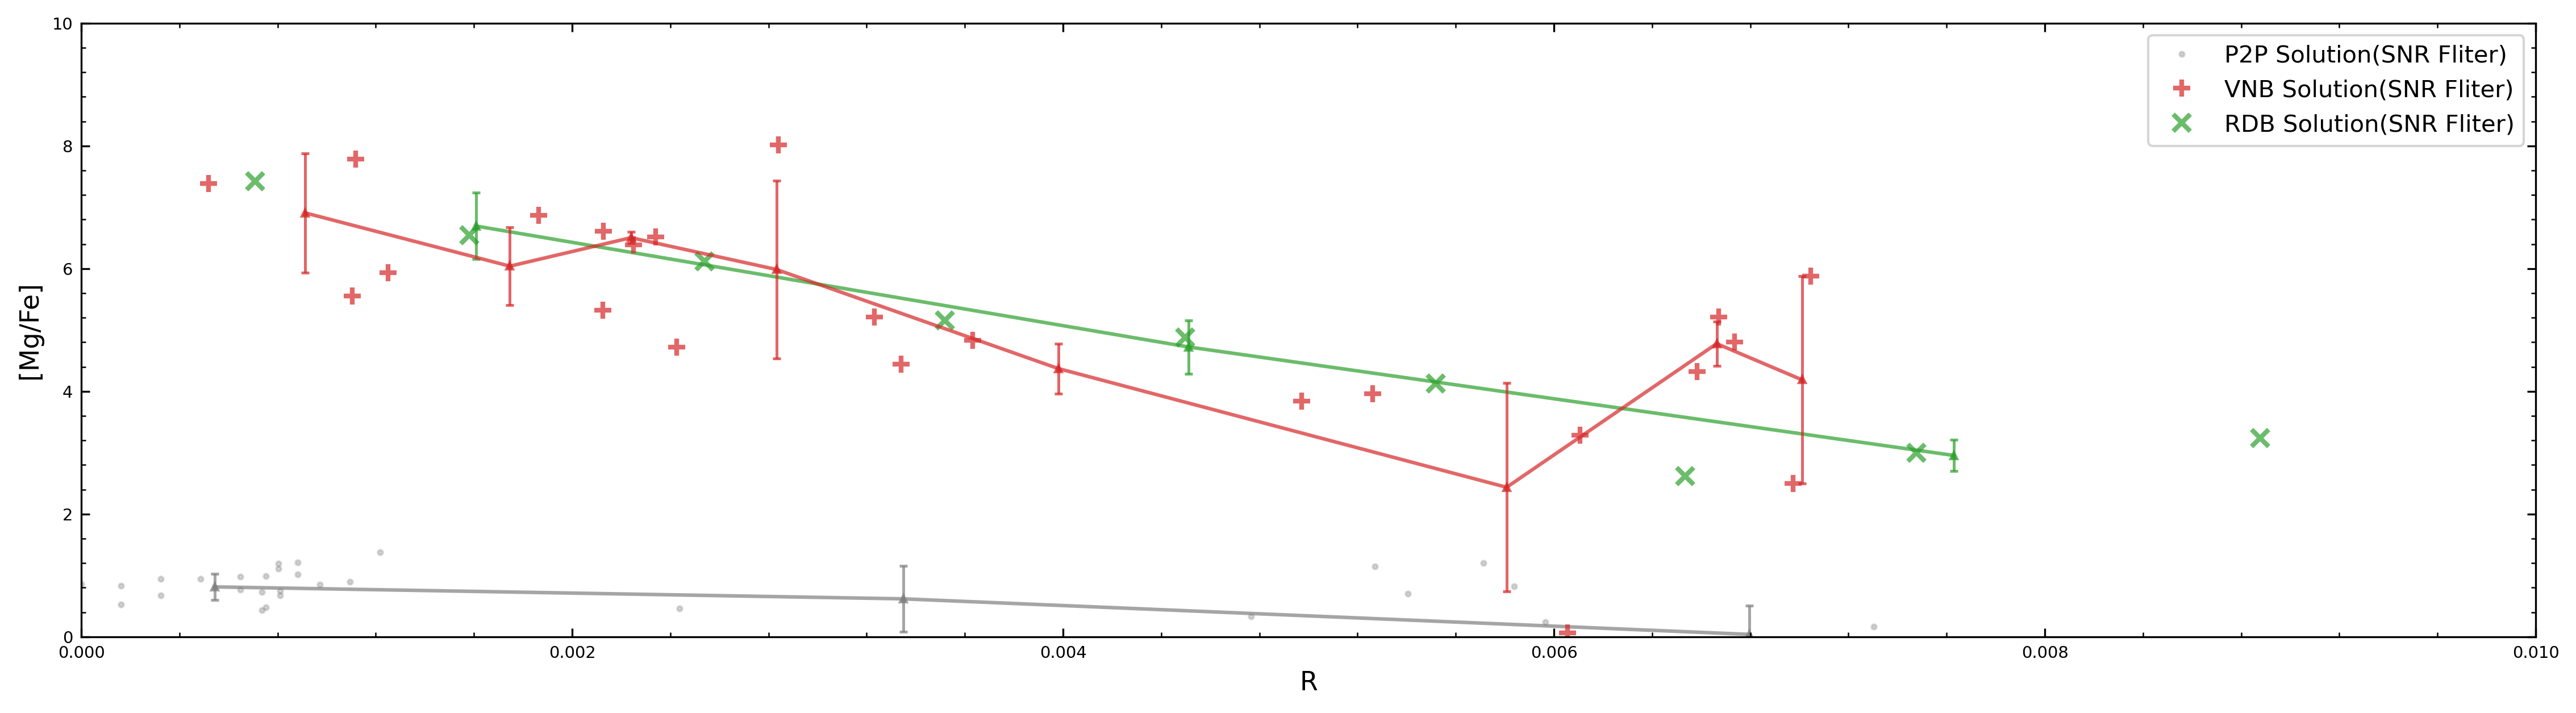

In [47]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['Mg_b_SI']*Galaxy_P2P_HSNR['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax1.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['Mg_b_SI']*Galaxy_VNB_HSNR['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax1.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['Mg_b_SI']*Galaxy_RDB_HSNR['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_P2P_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_VNB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_RDB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

# ax1.plot([-1,1], [MgFeR_Lim,MgFeR_Lim], '--', color='tab:pink', lw=2, alpha=.9, label='[Mg/Fe] = {:}'.format(MgFeR_Lim))

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,10)
ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg/Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

# Map

## Fe/Mg map

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\180216750.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs2[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\180216750.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\180216750.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Loca

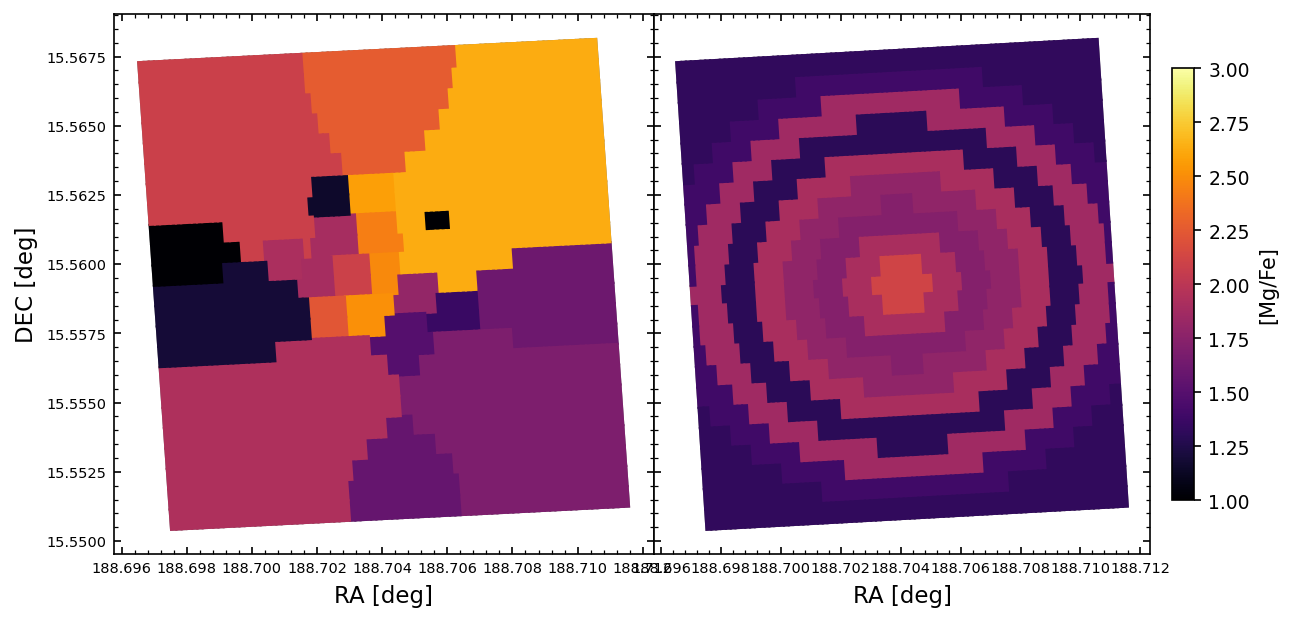

In [48]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8,4), dpi=150, tight_layout=True)
# gs1 = gridspec.GridSpec(1, 1)
# gs1.update(left=0.05, right=.35, bottom=0.05, top=0.95, hspace=0.0)
# ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.05, right=.5, bottom=0.05, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.5, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax3 = plt.subplot(gs3[0])

LHS = 1
RHS = 3
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

# for Index_num in range(len(Galaxy_P2P_HSNR)):
#         POS_NL = (Galaxy_P2P_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
#         for i in range(len(POS_NL)):
#                 POS_NL[i] = int(POS_NL[i])
#         for k_index in POS_NL:
#                 i = int(k_index/max(Galaxy_info.col))
#                 j = k_index%max(Galaxy_info.col)

#                 Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#                 Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#                 ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                 [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                 color=cmap_1.to_rgba(Galaxy_P2P_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_P2P_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_VNB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_RDB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


# ax2.axes.yaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
# ax2.axes.yaxis.set_label_position("right")

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
# ax1.set_xlabel(r'RA [deg]', size=11)
ax2.set_xlabel(r'RA [deg]', size=11)
ax3.set_xlabel(r'RA [deg]', size=11)
# ax1.set_ylabel(r'DEC [deg]', size=11)
ax2.set_ylabel(r'DEC [deg]', size=11)

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'[Mg/Fe]')

# ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## Spectrum Index map

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3867138189.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3867138189.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3867138189.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

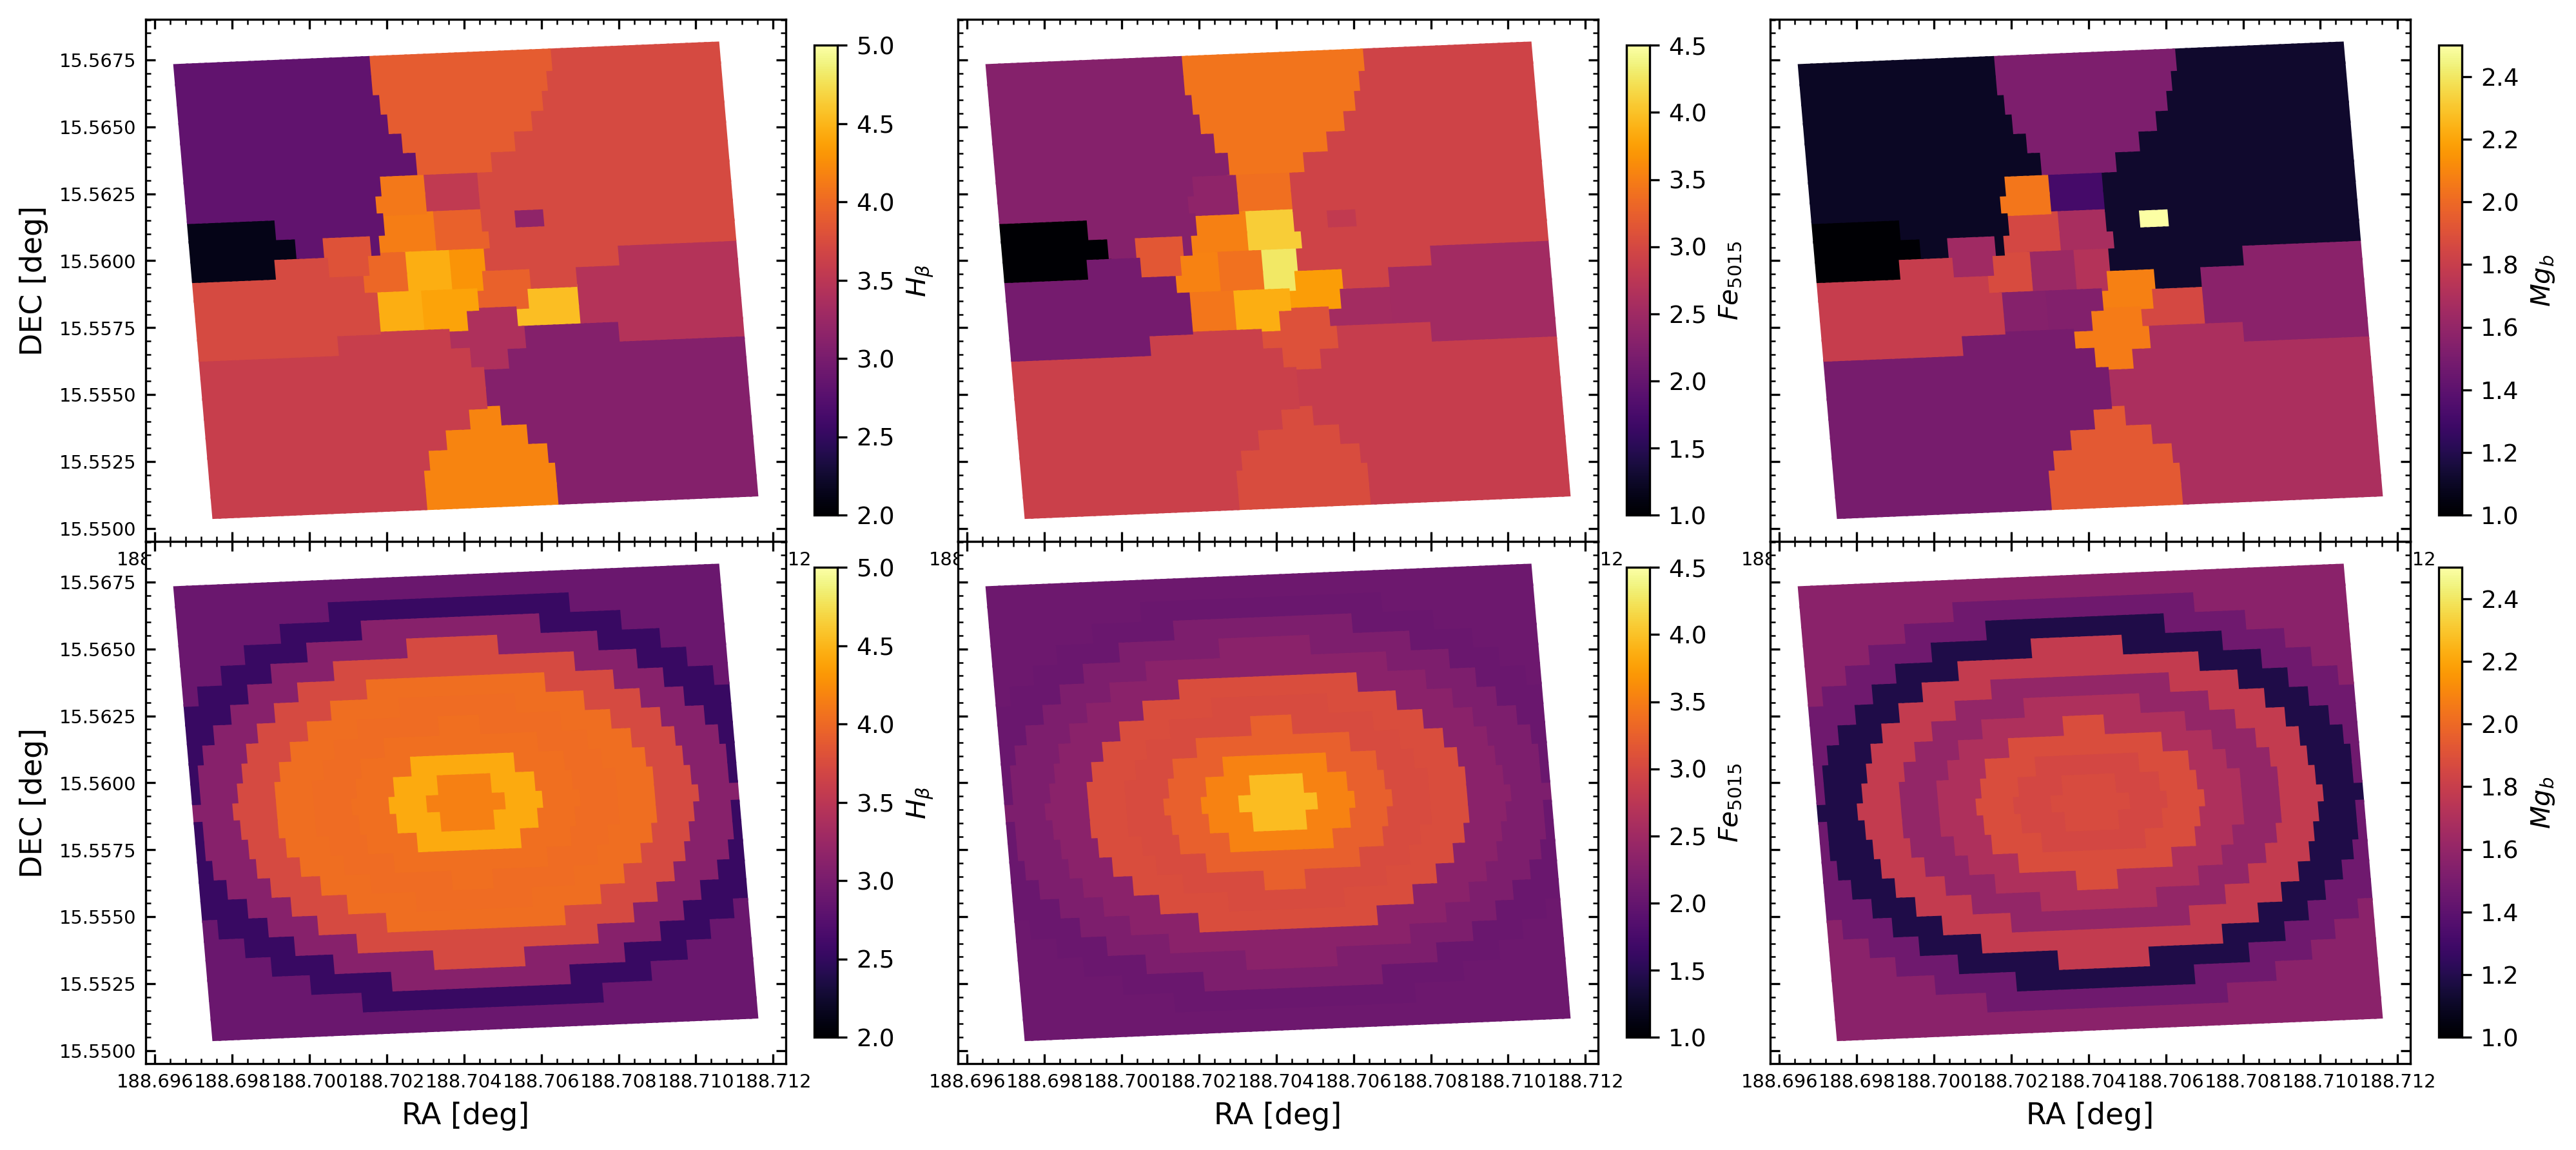

In [49]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12,6), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=.3, bottom=0.5, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS_1 = 2
RHS_1 = 5
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS_1, vmax=RHS_1)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

gs4 = gridspec.GridSpec(1, 1)
gs4.update(left=0.0, right=.3, bottom=0.05, top=0.5, hspace=0.0)
ax4 = plt.subplot(gs4[0])

LHS_1 = 2
RHS_1 = 5
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS_1, vmax=RHS_1)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.35, right=.65, bottom=0.5, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])

LHS_2 = 1
RHS_2 = 4.5
cm2 = plt.cm.get_cmap('inferno')
norm_2 = mpl.colors.Normalize(vmin=LHS_2, vmax=RHS_2)
cmap_2 = mpl.cm.ScalarMappable(norm=norm_2, cmap=mpl.cm.get_cmap('inferno'))
cmap_2.set_array([])
cb2 = plt.colorbar(cmap_2,fraction=0.04,pad=0.04,shrink=0.9)
cb2.ax.tick_params(labelsize=9)
cb2.set_label(label=r'$ Fe_{5015} $')

gs5 = gridspec.GridSpec(1, 1)
gs5.update(left=0.35, right=.65, bottom=0.05, top=0.5, hspace=0.0)
ax5 = plt.subplot(gs5[0])

LHS_2 = 1
RHS_2 = 4.5
cm2 = plt.cm.get_cmap('inferno')
norm_2 = mpl.colors.Normalize(vmin=LHS_2, vmax=RHS_2)
cmap_2 = mpl.cm.ScalarMappable(norm=norm_2, cmap=mpl.cm.get_cmap('inferno'))
cmap_2.set_array([])
cb2 = plt.colorbar(cmap_2,fraction=0.04,pad=0.04,shrink=0.9)
cb2.ax.tick_params(labelsize=9)
cb2.set_label(label=r'$ Fe_{5015} $')

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.7, right=1, bottom=0.5, top=0.95, hspace=0.0)
ax3 = plt.subplot(gs3[0])

LHS_3 = 1
RHS_3 = 2.5
cm3 = plt.cm.get_cmap('inferno')
norm_3 = mpl.colors.Normalize(vmin=LHS_3, vmax=RHS_3)
cmap_3 = mpl.cm.ScalarMappable(norm=norm_3, cmap=mpl.cm.get_cmap('inferno'))
cmap_3.set_array([])
cb3 = plt.colorbar(cmap_3,fraction=0.04,pad=0.04,shrink=0.9)
cb3.ax.tick_params(labelsize=9)
cb3.set_label(label=r'$ Mg_{b} $')

gs6 = gridspec.GridSpec(1, 1)
gs6.update(left=0.7, right=1, bottom=0.05, top=0.5, hspace=0.0)
ax6 = plt.subplot(gs6[0])

LHS_3 = 1
RHS_3 = 2.5
cm3 = plt.cm.get_cmap('inferno')
norm_3 = mpl.colors.Normalize(vmin=LHS_3, vmax=RHS_3)
cmap_3 = mpl.cm.ScalarMappable(norm=norm_3, cmap=mpl.cm.get_cmap('inferno'))
cmap_3.set_array([])
cb3 = plt.colorbar(cmap_3,fraction=0.04,pad=0.04,shrink=0.9)
cb3.ax.tick_params(labelsize=9)
cb3.set_label(label=r'$ Mg_{b} $')

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'H_beta_SI']))

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_2.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Mg_b_SI']))

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_3.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax4.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'H_beta_SI']))

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax5.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_2.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Mg_b_SI']))

# -----------------------------------------------------------------------------------------------

# for i in range(Galaxy_info.cube.shape[1]):
#     for j in range(Galaxy_info.cube.shape[2]):
#             Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
#             Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
#             ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
#                     [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
#                     color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax6.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_3.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax4.xaxis.set_minor_locator(AutoMinorLocator(5))
ax4.yaxis.set_minor_locator(AutoMinorLocator(5))
ax4.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax5.xaxis.set_minor_locator(AutoMinorLocator(5))
ax5.yaxis.set_minor_locator(AutoMinorLocator(5))
ax5.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax6.xaxis.set_minor_locator(AutoMinorLocator(5))
ax6.yaxis.set_minor_locator(AutoMinorLocator(5))
ax6.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax2.axes.yaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
ax5.axes.yaxis.set_ticklabels([])
ax6.axes.yaxis.set_ticklabels([])
# ax2.axes.yaxis.set_label_position("right")

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
# ax1.set_xlabel(r'RA [deg]', size=11)
# ax2.set_xlabel(r'RA [deg]', size=11)
# ax3.set_xlabel(r'RA [deg]', size=11)
ax4.set_xlabel(r'RA [deg]', size=11)
ax5.set_xlabel(r'RA [deg]', size=11)
ax6.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)
ax4.set_ylabel(r'DEC [deg]', size=11)

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

cb2.ax.tick_params(labelsize=9)
cb2.set_label(label=r'$ Fe_{5015} $')

cb3.ax.tick_params(labelsize=9)
cb3.set_label(label=r'$ Mg_{b} $')

# ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3308184956.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


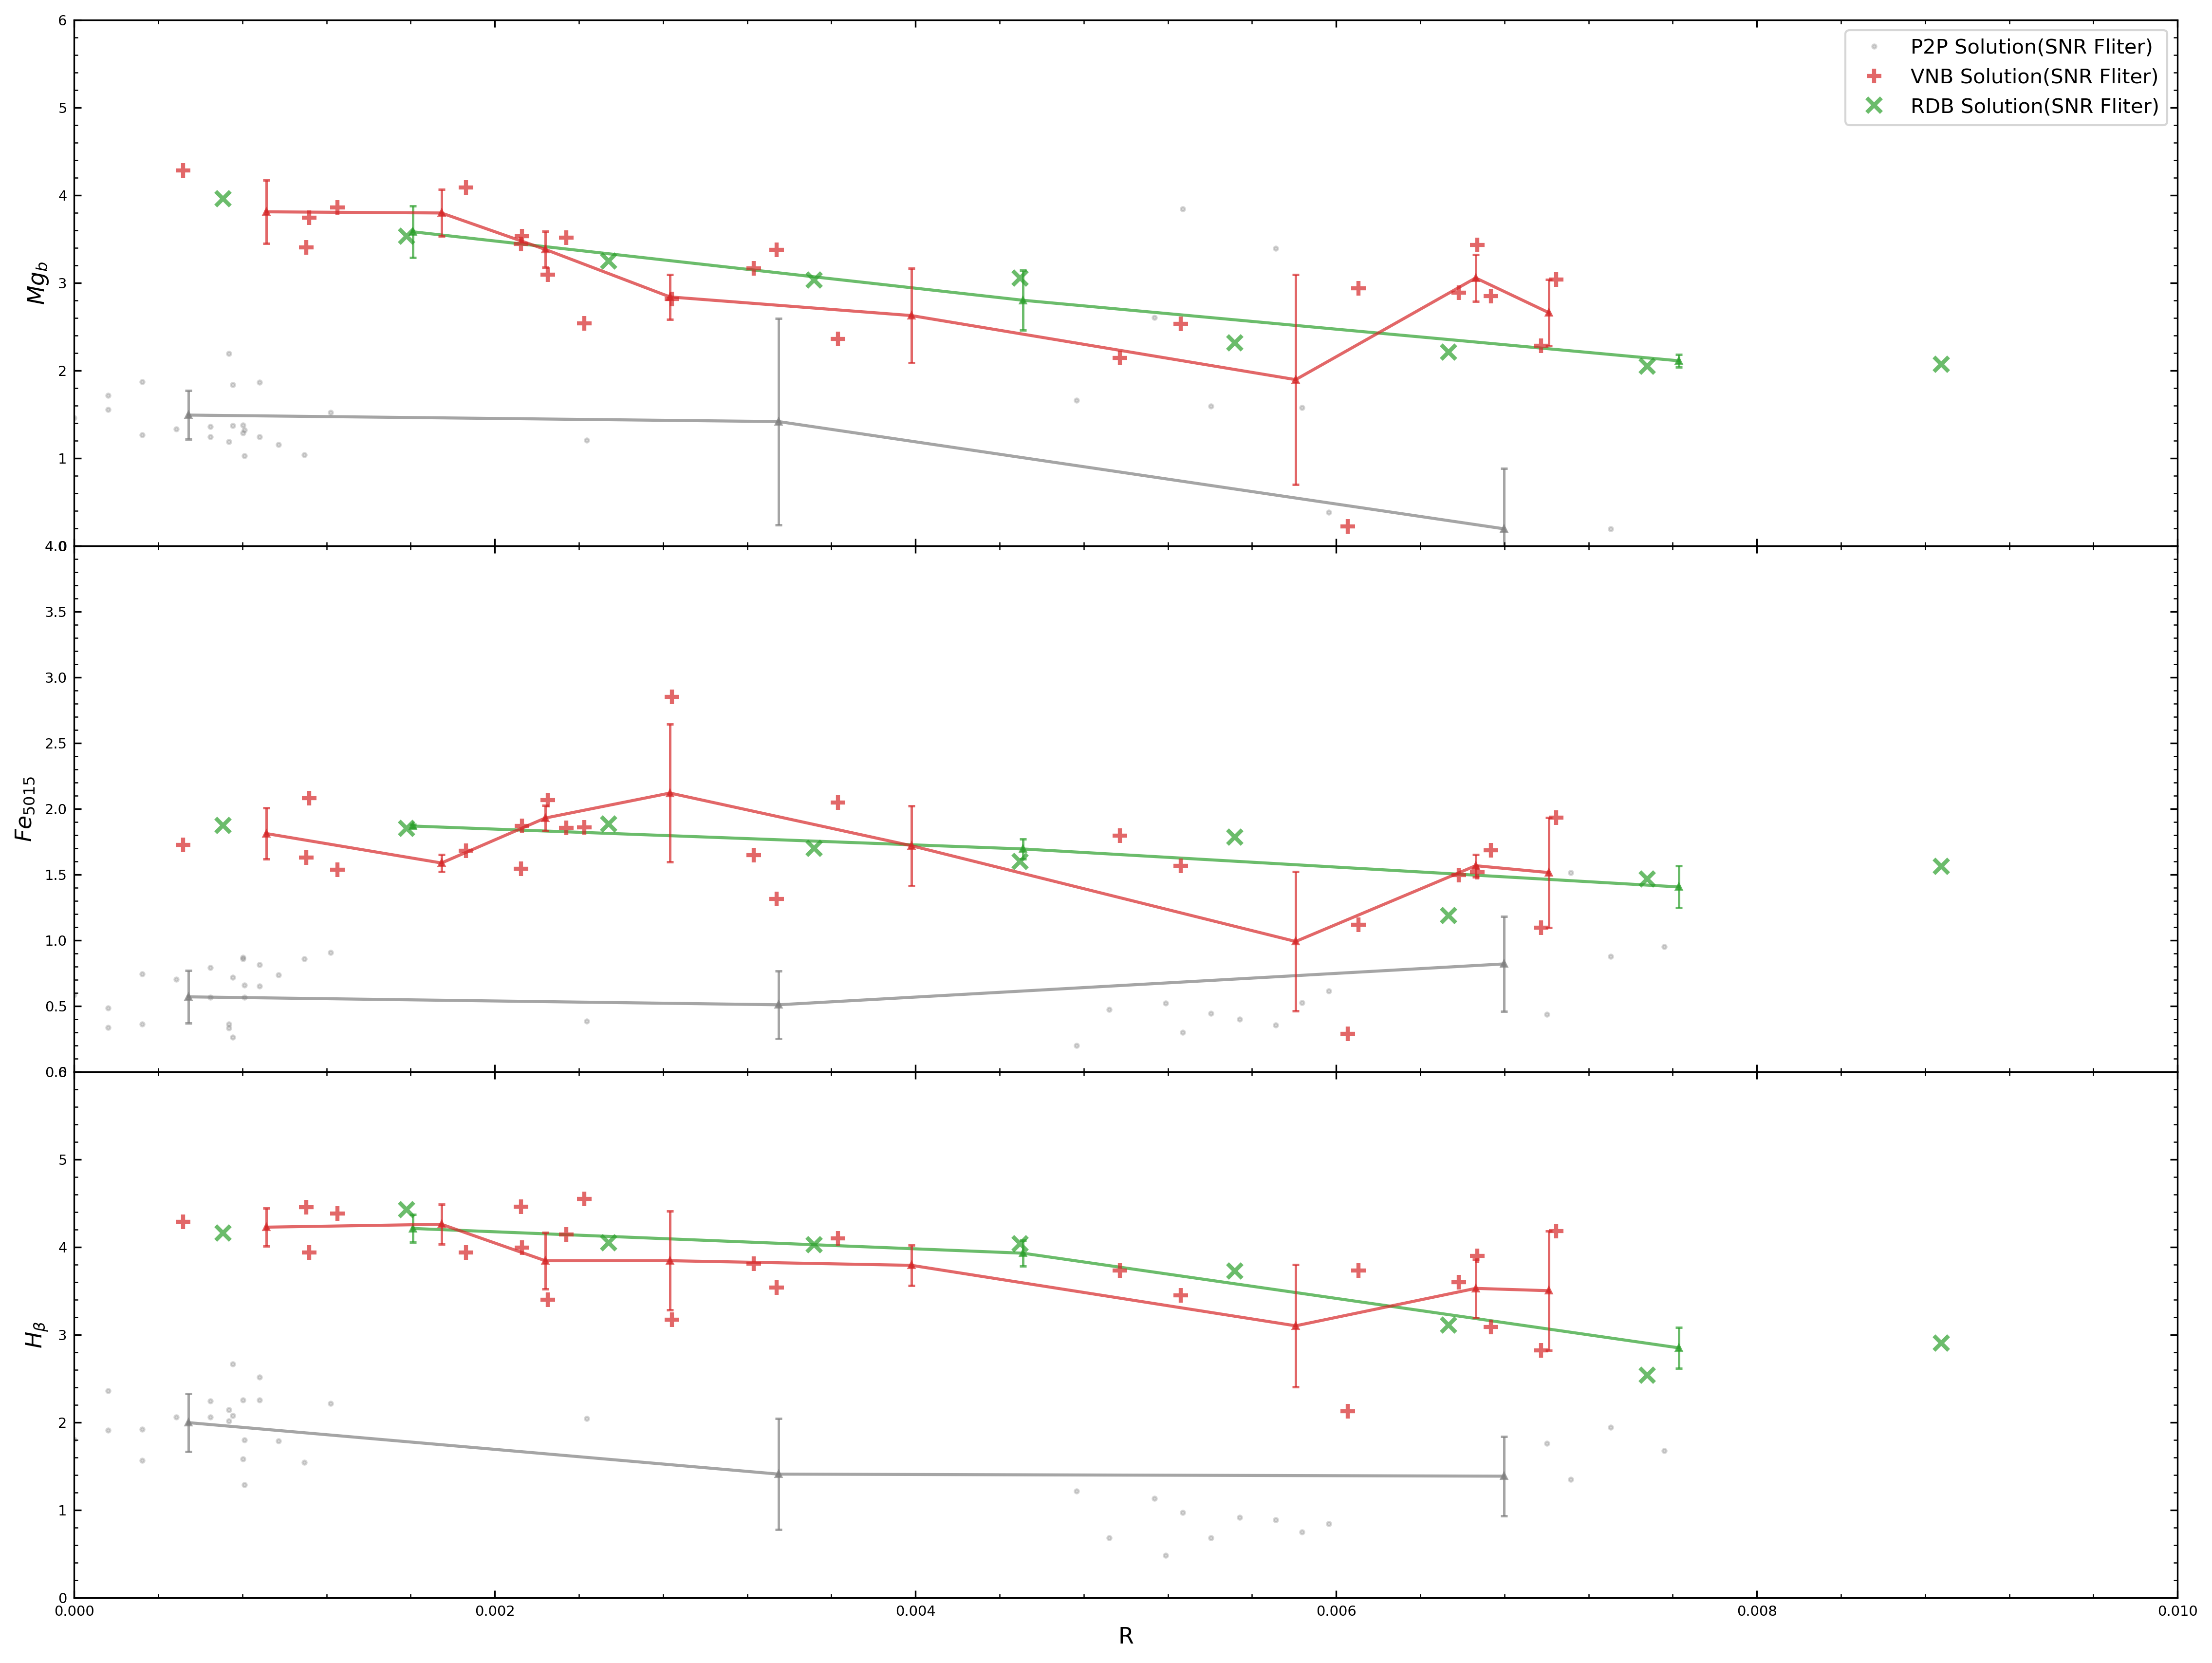

In [50]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
ax2 = plt.subplot(gs2[0])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
ax3 = plt.subplot(gs3[0])

ax1.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['Mg_b_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax1.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['Mg_b_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax1.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['Mg_b_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['Mg_b_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['Mg_b_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['Mg_b_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax2.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax2.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax2.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax2.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax2.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax2.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['H_beta_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax3.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['H_beta_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax3.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['H_beta_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['H_beta_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['H_beta_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['H_beta_SI']), Group_K=3)

ax3.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax3.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax3.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,6)
ax1.set_xlim(0,0.01)
ax2.set_ylim(0,4)
ax2.set_xlim(0,0.01)
ax3.set_ylim(0,6)
ax3.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax3.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'$ Mg_{b} $', size=11)
ax2.set_ylabel(r'$ Fe_{5015} $', size=11)
ax3.set_ylabel(r'$ H_{\beta} $', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3642904653.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3642904653.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\3642904653.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\L

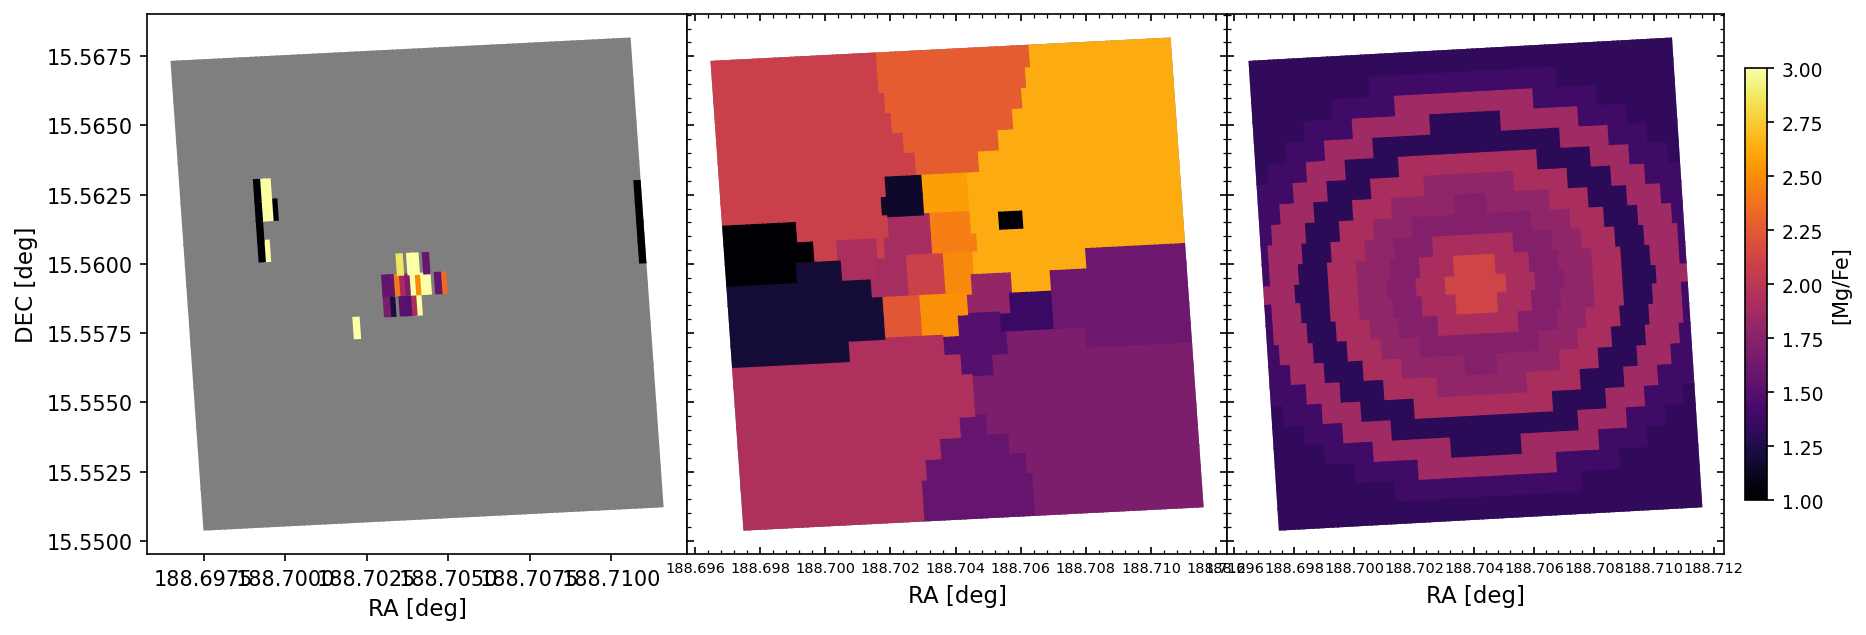

In [51]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.35, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.35, right=.65, bottom=0.05, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.65, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax3 = plt.subplot(gs3[0])

LHS = 1
RHS = 3
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_P2P_HSNR)):
        POS_NL = (Galaxy_P2P_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_P2P_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_P2P_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_VNB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_RDB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax2.axes.yaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
# ax2.axes.yaxis.set_label_position("right")

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'RA [deg]', size=11)
ax2.set_xlabel(r'RA [deg]', size=11)
ax3.set_xlabel(r'RA [deg]', size=11)
# ax1.set_ylabel(r'DEC [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'[Mg/Fe]')

# ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\2328360665.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\2328360665.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_2568\2328360665.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\L

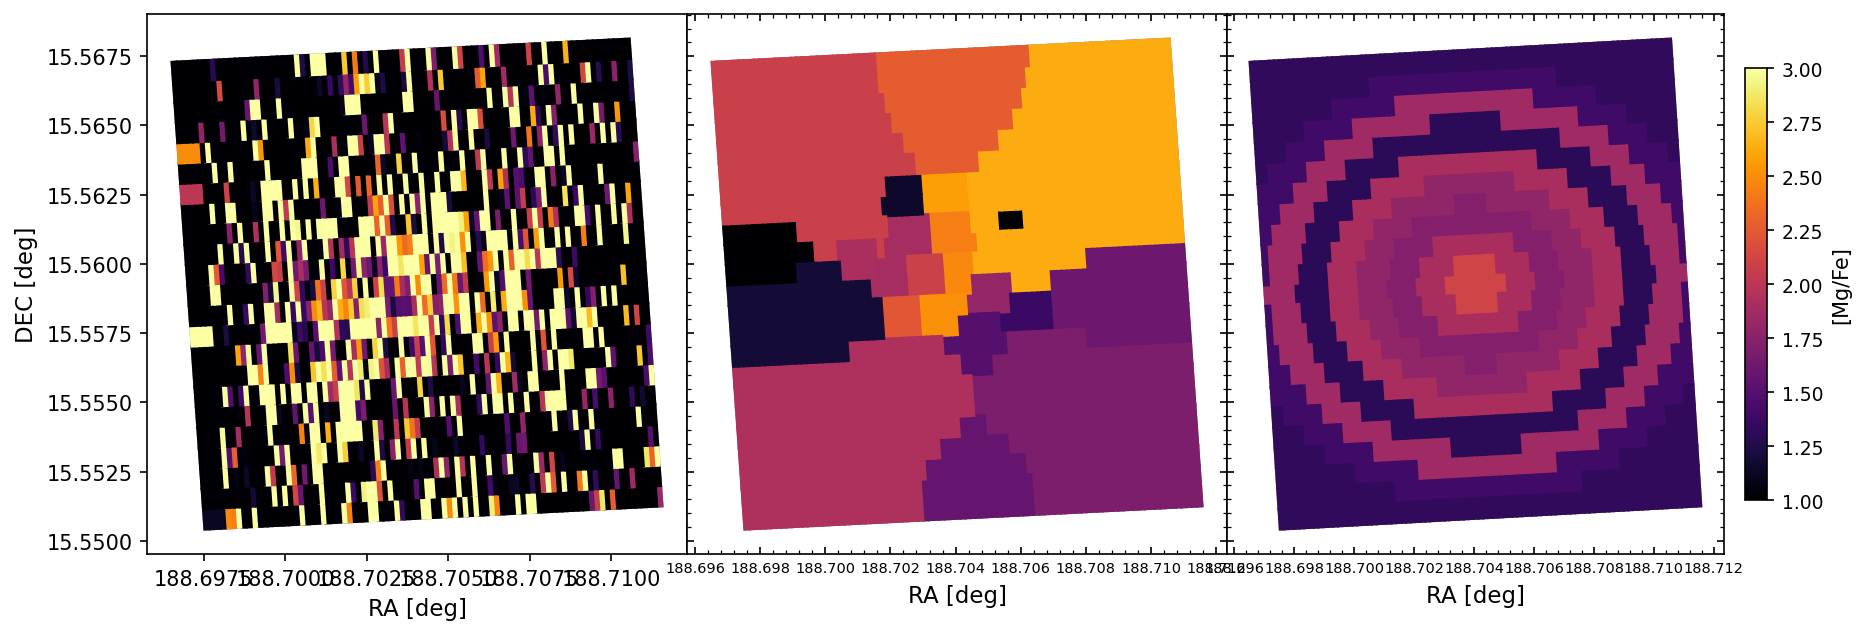

In [52]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.35, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.35, right=.65, bottom=0.05, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.65, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax3 = plt.subplot(gs3[0])

LHS = 1
RHS = 3
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_P2P.loc[Index_num,'Mg_b_SI']/Galaxy_P2P.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_VNB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_RDB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax2.axes.yaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
# ax2.axes.yaxis.set_label_position("right")

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'RA [deg]', size=11)
ax2.set_xlabel(r'RA [deg]', size=11)
ax3.set_xlabel(r'RA [deg]', size=11)
# ax1.set_ylabel(r'DEC [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'[Mg/Fe]')

# ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')